<a href="https://colab.research.google.com/github/vaibhavsundharam/Facial-Key-Points-Detection/blob/master/Facial_Key_Points_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facial Key Point Detection 

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:




*   tracking faces in images and video  
*   analysing facial expressions
*   detecting dysmorphic facial signs for medical diagnosis
*   biometrics / face recognition








Detecing facial keypoints is a very challenging problem.  Facial features  ary greatly from one individual to another, and even for a single individual,  here is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.

Acknowledgements:
The data set for this competition was graciously provided by Dr. Yoshua Bengio of the University of Montreal. James Petterson.

#Data

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data Files: kaggle competitions download -c facial-keypoints-detection


*   training.csv: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
*   test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels



In [1]:
# Mounting drive
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
#changing the working directory
%cd /content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection

/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection


In [ ]:
#Run the following code to provide the config path to kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Machine Learning/Kaggle"

In [ ]:
# download the dataset
! kaggle competitions download -c facial-keypoints-detection

SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)
 72% 43.0M/60.1M [00:00<00:00, 75.3MB/s]
100% 60.1M/60.1M [00:00<00:00, 122MB/s] 
 44% 7.00M/16.0M [00:00<00:00, 69.5MB/s]
100% 16.0M/16.0M [00:00<00:00, 77.9MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  training.zip
replace training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: training.csv            

Archive:  test.zip
  inflating: test.csv                

2 archives were successfully processed.


#General initializations

In [3]:
import torch
import sys
import os
from __future__ import print_function, division
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.transform import resize
import torch.nn as nn
import torch.nn.functional as F
import cv2
import re
import pandas as pd
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [4]:
torch.cuda.is_available()

True

In [5]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#Data Preprocessing

In [6]:
# Loading the csv files (give path to your cvs files)
train_csv=pd.read_csv("/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/training.csv")
test_csv=pd.read_csv("/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/test.csv")
IdLookupTable_csv=pd.read_csv("/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/IdLookupTable.csv")

In [ ]:
# exploring the train data, each row is an example
train_csv.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


As mentiones in the data section the training file has some data missing. So the nect step is to figure out the number of missing values. The following code does that.


In [ ]:
# total number of missing values
print(f"The total number of missing values in the train dataset is/are: {train_csv.isnull().sum().sum()}")

The total number of missing values in the train dataset is/are: 105412


Some of the most common ways of dealing with missing data are.


*   Replacing
*   Deleting entries with missing values (in is not usually preferred as it reduced the number of training examples)

We perform replacement, in which we replace the missing value with mean.


In [ ]:
# Replace using mean and getting feature list
key_points=list()
for column in train_csv: # itterating over each column
  if column!="Image":      
    key_points.append(column)
    mean=train_csv[column].mean() 
    train_csv[column].fillna(mean, inplace=True) # replacing empty value with the mean 
   

print(f"The key point  list is: {key_points}")

The key point  list is: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']


In [ ]:
#  Checking again to see the number of missing values
print(f"The total number of missing values in the train dataset is/are: {train_csv.isnull().sum().sum()}")

The total number of missing values in the train dataset is/are: 0


Now we will split the training data into two parts, one will be used for training the neural network and the other will be used for validation. 


In [ ]:
'''mask = np.random.rand(len(train_csv)) <=0.8  # approx 80% in training and 20% in validation
train_split=train_csv[mask]
val_split=train_csv[~mask]

# saving the train and validation split (the files will be saved in your working directory)
train_split.to_csv("train_split.csv", index= False)
val_split.to_csv("val_split.csv", index= False)'''

#Data Loading and Data Augmentation

In [7]:
# custom dataset 
from torch.utils.data import Dataset, DataLoader

class faces(Dataset):
  def __init__(self, csv_loc, transform=None):
    self.csv=pd.read_csv(csv_loc)   
    self.transform=transform  

  def __len__(self):
    return len(self.csv)
  
  def __getitem__(self, idx):
    image=self.transform(np.array(self.csv.iloc[idx][-1].split(" "), dtype="float").reshape(96,96))   
    key_points=np.array(self.csv.iloc[idx][:-1], dtype="float")    
    return image, key_points

In [8]:
train_dataset=faces(csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/train_split.csv", transform=transforms.Compose([transforms.ToTensor()]))
val_dataset= faces(csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/val_split.csv", transform=transforms.Compose([transforms.ToTensor()]))
test_dataset= faces(csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/test.csv", transform=transforms.Compose([transforms.ToTensor()]))

In [9]:
print(f"Number of examples in training dataset: {len(train_dataset)}")
print(f"Number of examples in validation dataset: {len(val_dataset)}")
print(f"Number of examples in test dataset: {len(test_dataset)}")

Number of examples in training dataset: 5657
Number of examples in validation dataset: 1392
Number of examples in test dataset: 1783


#Data Exploration

Let us look at an image in the traing dataset.

In [10]:
def image_show(sample, csv_loc):
  fig, axs= plt.subplots(1, 2) 
  csv=pd.read_csv(csv_loc)
  image=np.array(csv.iloc[sample][-1].split(" "), dtype="float").reshape(96,96)
  image_keypoints=np.copy(image)
  key_points = np.array(csv.iloc[sample][:-1], dtype="int32")
  key_points_x=np.take(key_points, range(0, 30, 2))
  key_points_y=np.take(key_points, range(1, 30, 2))
  x_y=zip(key_points_x, key_points_y)

  for x, y in x_y:
    image_keypoints[y][x]=255 

  axs[0].imshow(image)
  axs[0].set_title("Original Image")
  axs[1].imshow(image_keypoints)  
  axs[1].set_title("Image with key points")

  return image, key_points

Sample image number: 1422



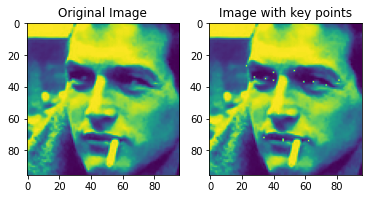

In [42]:
sample=np.random.randint(0, len(train_dataset)) # randomly selecting an example from train_split
print(f"Sample image number: {sample}\n")
image ,feature=image_show(sample, csv_loc="/content/gdrive/My Drive/Machine Learning/Kaggle/Facial Key Points Detection/train_split.csv")

#Helper functions

In [43]:
def cal_loss(model, loader, criterion, eps=1e-6):
  loss_total=0 
  total_step=len(loader)

  for x, y in loader:
    x=x.to(device=device, dtype=torch.float)
    y=y.to(device=device, dtype=torch.long)
    y_pred=model(x)                  
    loss=torch.sqrt(criterion(y_pred, y) + eps) 
    loss_total+=loss.item()
  
  return (loss_total/total_step)

In [44]:
# solver function for Neural Network

def Solver_NN(model, train_loader, val_loader, optim, criterion, device, scheduler, print_every=10, epoch=51, lr=1e-1, eps=1e-6):
  print("Solver Initiated")  
  model=model.to(device) # sending model to GPU
  if device =="cpu":
    print("Cuda unavailable, model successfully sent to the CPU\n")
  else:
    print("Model successfully sent to the GPU\n")

  print_every=print_every
  total_step = len(train_loader)
  counter=0

  for e in range(epoch):
    running_loss = 0.0    
    epoch_loss=0.0
    for i, (x,y) in enumerate(train_loader):
      optim.zero_grad()
          
      x=x.to(device=device, dtype=torch.float)
      y=y.to(device=device, dtype=torch.float)
     
      #forward pass########
      y_pred=model(x)                  
      loss=torch.sqrt(criterion(y_pred, y) + eps)         
      ####################
      
      # backward pass#######     
      loss.backward()
      optim.step()
      ####################      
      running_loss += loss.item()      
      if (i+1) % print_every == 0:       # print every 10
        print ("Epoch [{}/{}], Step [{}/{}] Loss: {}".format(counter+1, epoch, i+1, total_step, running_loss/print_every))
        running_loss = 0.0    
    counter+=1     

    with torch.no_grad():            
      train_loss= cal_loss(model, train_loader, criterion)
      val_loss= cal_loss(model, val_loader, criterion)
      scheduler.step(val_loss)
      print(f"Train loss in epoch {e+1} is {train_loss}") 
      print(f"Validation loss in epoch {e+1} is {val_loss}\n ")         
  return model

# Neural Network

In [45]:
class Resnet(nn.Module):
  def __init__(self, inp_channels, output, model):
    super().__init__()
    self.inp_channels=inp_channels
    self.output=output
    self.first=nn.Sequential(nn.Conv2d(self.inp_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), nn.ReLU(inplace=True))
    self.cnn=nn.Sequential(*(list(model.children())[1:-1]), nn.Flatten())    
    self.fc = nn.Sequential(nn.Linear(512, 512), nn.ReLU(inplace= True), nn.Linear(512, 128), nn.ReLU(inplace=True), nn.Linear(128, self.output))
      

  def forward(self, x):  

    x=self.first(x)
    #print(f"1: {x.shape}")

    x=self.cnn(x)
   #print(f"2: {x.shape}")

    x=self.fc(x)
    #print(f"3 {x.shape}")

    return x

In [55]:
resnet=torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
num_input_channels=1 # since it's a black and white image
output= 30  # number of keypoints
model= Resnet(num_input_channels, output, resnet)
print(model)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Resnet(
  (first): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU(inplace=True)
  )
  (cnn): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mo

In [56]:
#criterion and optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr=0.01
criterion=nn.MSELoss(reduction="mean") # loss criterion 
optim=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01) # optimizer 
scheduler= ReduceLROnPlateau(optim, mode="min", factor=0.1, patience=5, verbose=True)

In [57]:
# loading training and validation data for the neural network

train_loader=DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=8) 
val_loader=DataLoader(val_dataset, batch_size= 512, shuffle=True, num_workers=8) 

In [ ]:
model=Solver_NN(model, train_loader, val_loader, optim, criterion, device, scheduler, print_every=5, epoch=101, lr=lr)

Solver Initiated
Model successfully sent to the GPU

Epoch [1/101], Step [5/12] Loss: 38.56621608734131
Epoch [1/101], Step [10/12] Loss: 13.600399208068847
Train loss in epoch 1 is 5.316479603449504
Validation loss in epoch 1 is 5.138659159342448
 
Epoch [2/101], Step [5/12] Loss: 6.823848915100098
Epoch [2/101], Step [10/12] Loss: 6.114264011383057
Train loss in epoch 2 is 4.148790121078491
Validation loss in epoch 2 is 4.010714530944824
 
Epoch [3/101], Step [5/12] Loss: 7.035579204559326
Epoch [3/101], Step [10/12] Loss: 9.034367179870605
Train loss in epoch 3 is 9.157655954360962
Validation loss in epoch 3 is 9.077943166097006
 
Epoch [4/101], Step [5/12] Loss: 5.429255580902099
Epoch [4/101], Step [10/12] Loss: 4.766960334777832
Train loss in epoch 4 is 5.730668544769287
Validation loss in epoch 4 is 5.625717798868815
 
Epoch [5/101], Step [5/12] Loss: 4.39129490852356
Epoch [5/101], Step [10/12] Loss: 3.9492001056671144
Train loss in epoch 5 is 4.033144454161326
Validation loss 